In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import scipy
import math
import random
import sklearn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from wordcloud import WordCloud
import missingno as msno
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
from tqdm import tqdm
nltk.download('punkt')
nltk.download('wordnet')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
articles = pd.read_csv('/content/drive/MyDrive/shared_articles.csv')
users = pd.read_csv('/content/drive/MyDrive/users_interactions.csv')

In [ ]:
articles. columns

Index(['timestamp', 'eventType', 'contentId', 'authorPersonId',
       'authorSessionId', 'authorUserAgent', 'authorRegion', 'authorCountry',
       'contentType', 'url', 'title', 'text', 'lang'],
      dtype='object')

In [ ]:
users. columns

Index(['timestamp', 'eventType', 'contentId', 'personId', 'sessionId',
       'userAgent', 'userRegion', 'userCountry'],
      dtype='object')

In [ ]:
articles.shape

(3122, 13)

In [ ]:
users.shape

(72312, 8)

In [ ]:
print(articles.isnull().sum())
print(users.isnull().sum())


timestamp             0
eventType             0
contentId             0
authorPersonId        0
authorSessionId       0
authorUserAgent    2442
authorRegion       2442
authorCountry      2442
contentType           0
url                   0
title                 0
text                  0
lang                  0
dtype: int64
timestamp          0
eventType          0
contentId          0
personId           0
sessionId          0
userAgent      15394
userRegion     15405
userCountry    15394
dtype: int64


In [ ]:
#identify duplicates

print(articles.duplicated(subset=['contentId']).sum())
print(users.duplicated(subset=['contentId']).sum())


65
69325


In [ ]:

print(articles.isnull().sum())
articles = articles.fillna('none')
articles.head()


timestamp             0
eventType             0
contentId             0
authorPersonId        0
authorSessionId       0
authorUserAgent    2442
authorRegion       2442
authorCountry      2442
contentType           0
url                   0
title                 0
text                  0
lang                  0
dtype: int64


,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,none,none,none,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,none,none,none,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,none,none,none,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,none,none,none,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,none,none,none,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [ ]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0,
   'BOOKMARK': 2.5,
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,
}

In [ ]:
users['eventStrength'] = users['eventType'].apply(lambda x: event_type_strength[x])
users_interactions_count_df = users.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))


# users: 657


In [ ]:
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))
print('# of interactions: %d' % len(users))


# users with at least 5 interactions: 138
# of interactions: 2987


In [ ]:
interactions_from_selected_users_df = users.merge(users_with_enough_interactions_df,
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions from users with at least 5 interactions: 2097


In [ ]:
def smooth_user_preference(x):
    return math.log(1+x, 2)

interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head()

# of unique user/item interactions: 2097


,personId,contentId,eventStrength
0,-9016528795238256703,-8796191278504623694,1.0
1,-9016528795238256703,-8762137947059829459,1.0
2,-9016528795238256703,-8535131855706279960,1.0
3,-9016528795238256703,-6878119266243511199,1.0
4,-9016528795238256703,-6732229745645090645,1.0


In [ ]:
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head()


# of unique user/item interactions: 2097


,personId,contentId,eventStrength
0,-9016528795238256703,-8796191278504623694,1.0
1,-9016528795238256703,-8762137947059829459,1.0
2,-9016528795238256703,-8535131855706279960,1.0
3,-9016528795238256703,-6878119266243511199,1.0
4,-9016528795238256703,-6732229745645090645,1.0


<Axes: >

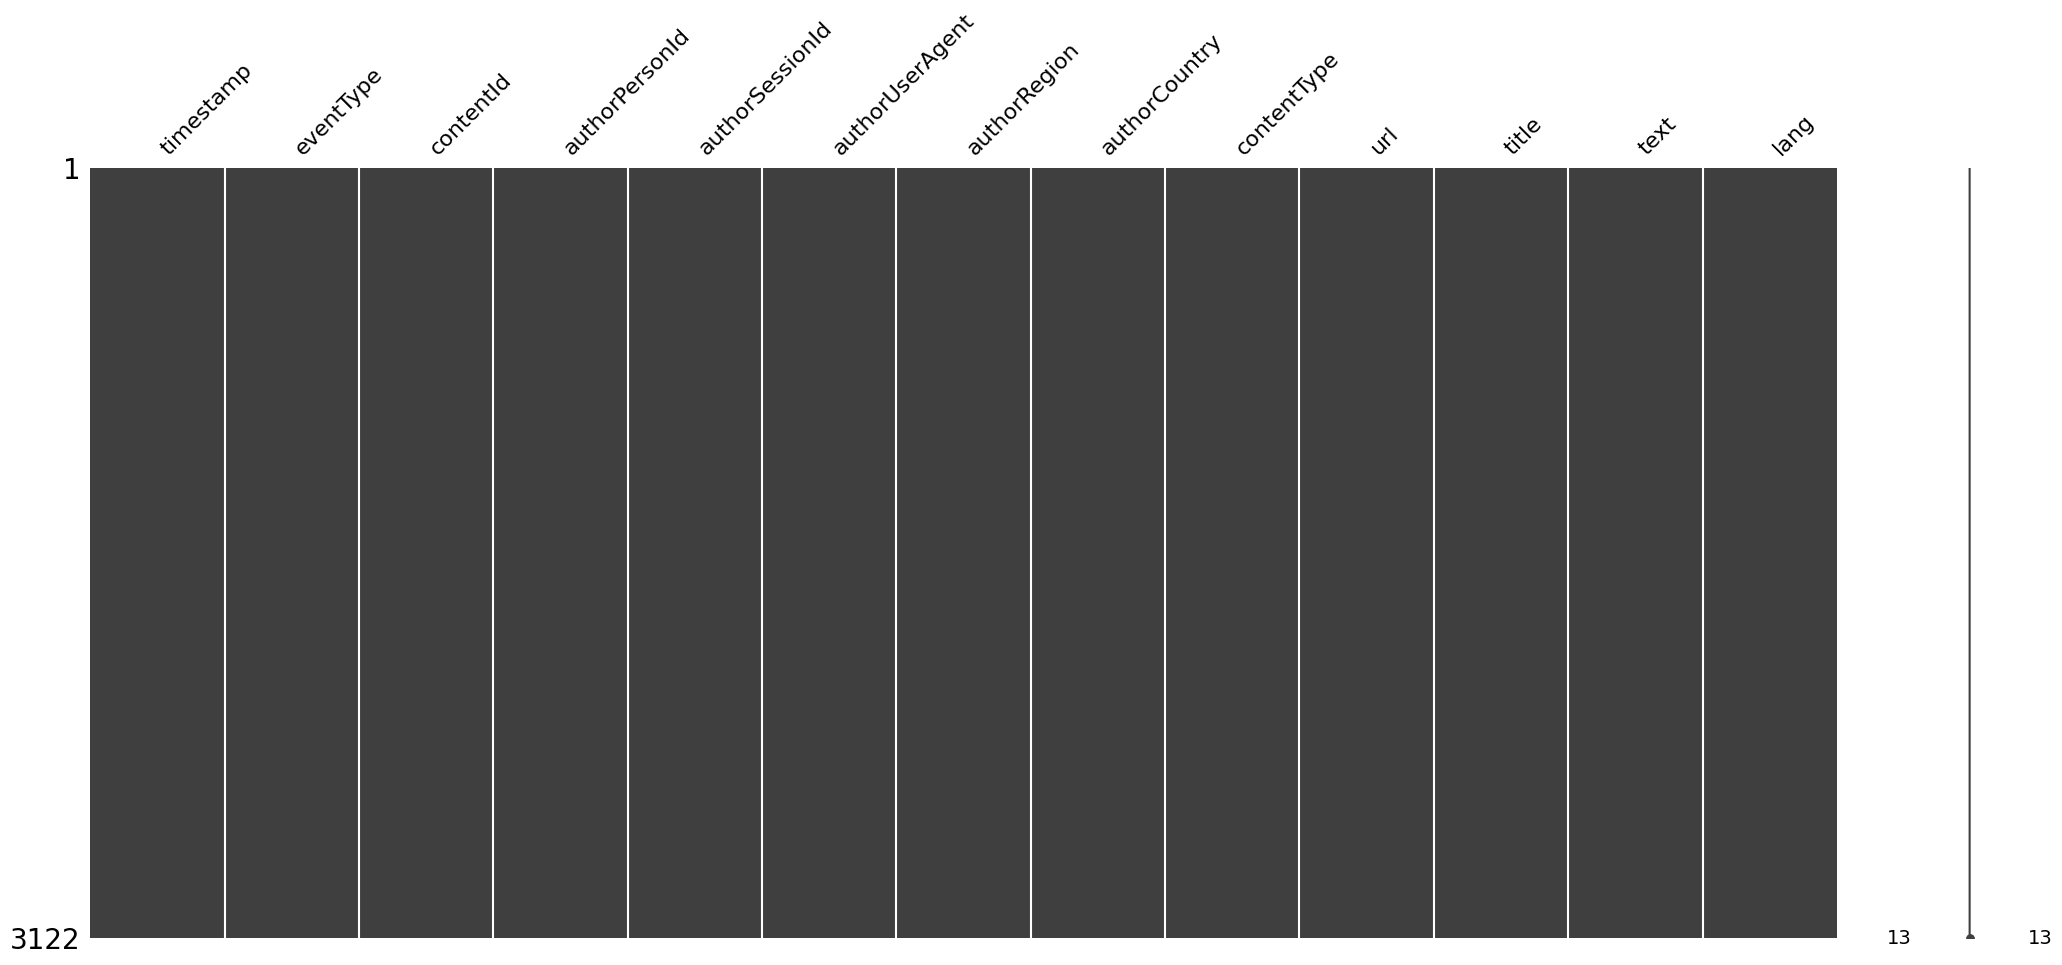

In [ ]:
msno.matrix(articles)


<Axes: >

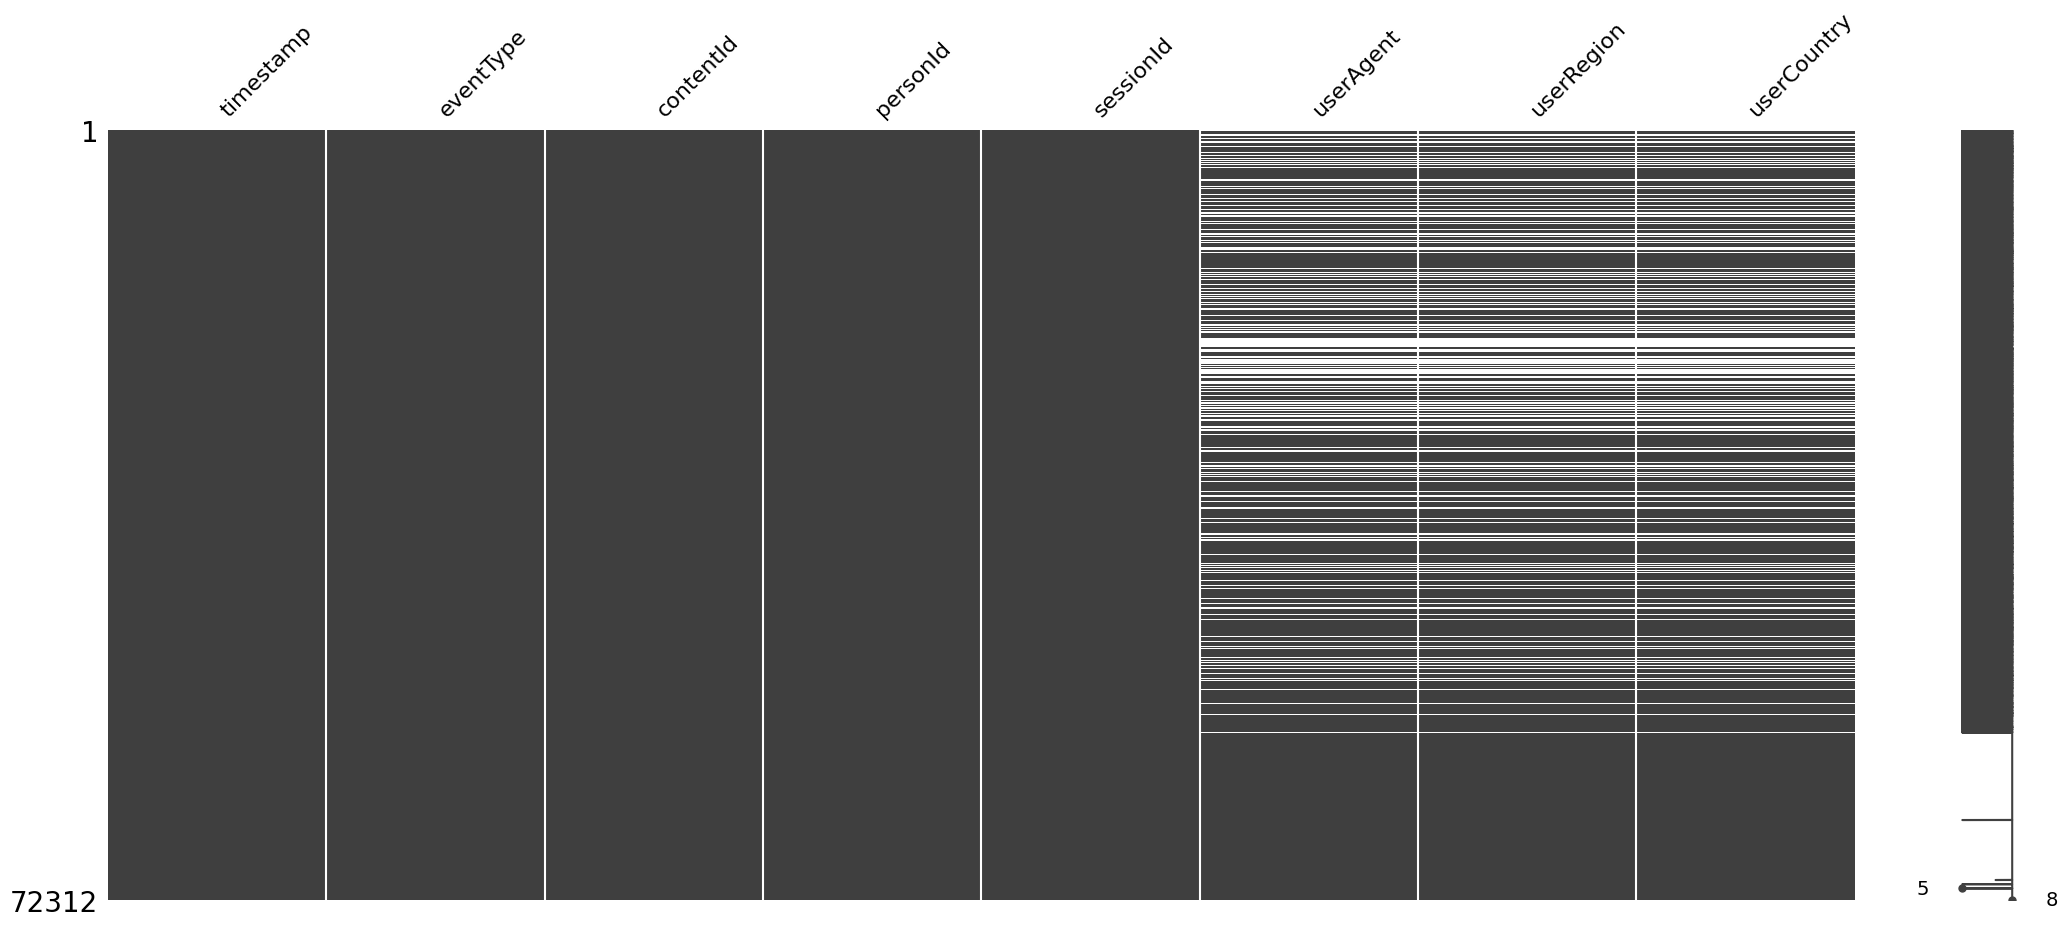

In [ ]:
msno.matrix(users)


In [ ]:
articles.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,none,none,none,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,none,none,none,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,none,none,none,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,none,none,none,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,none,none,none,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


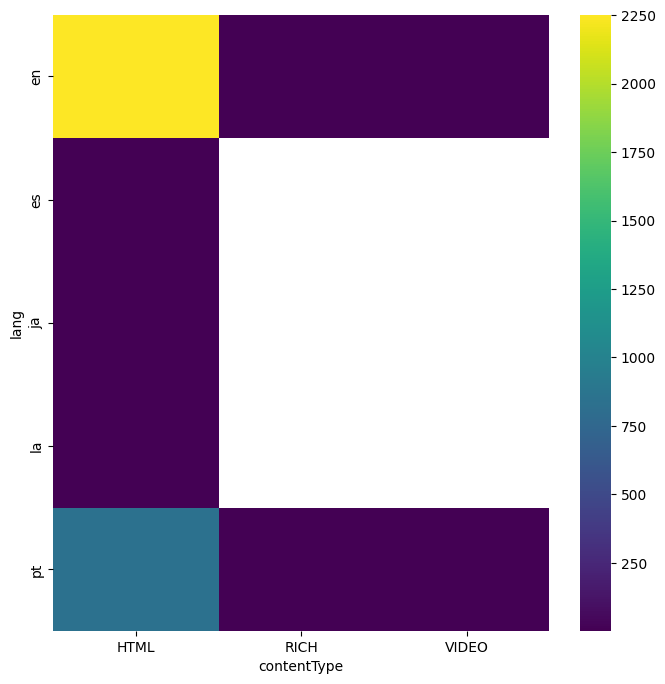

In [ ]:

plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['lang'].value_counts()
    for x_label, grp in articles.groupby('contentType')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('contentType')
_ = plt.ylabel('lang')

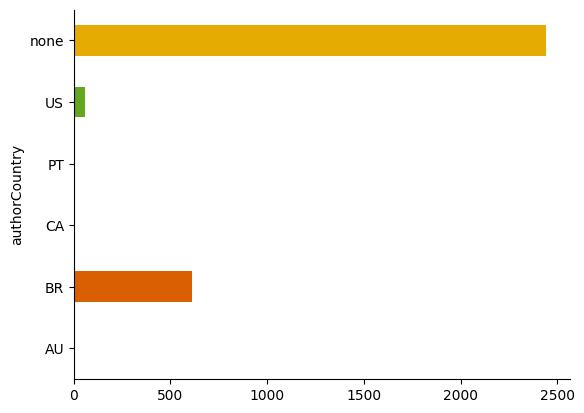

In [ ]:
# title authorCountry

from matplotlib import pyplot as plt
import seaborn as sns
articles.groupby('authorCountry').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

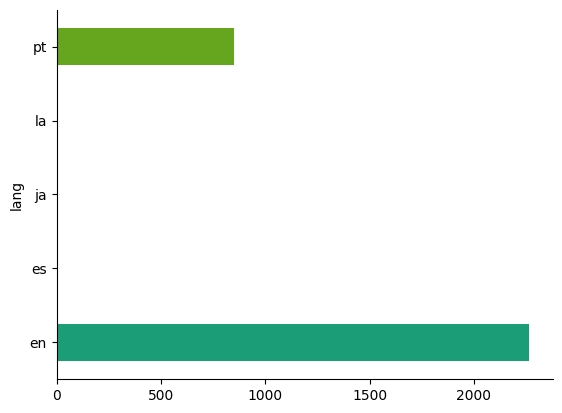

In [ ]:
# title lang

from matplotlib import pyplot as plt
import seaborn as sns
articles.groupby('lang').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

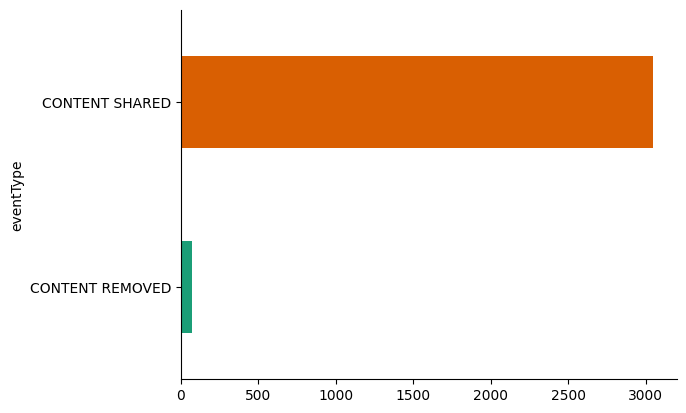

In [ ]:
# title eventType

from matplotlib import pyplot as plt
import seaborn as sns
articles.groupby('eventType').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
users.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


<ipython-input-19-a355fbaeb51f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(users, x='contentId', y='eventType', inner='box', palette='Dark2')


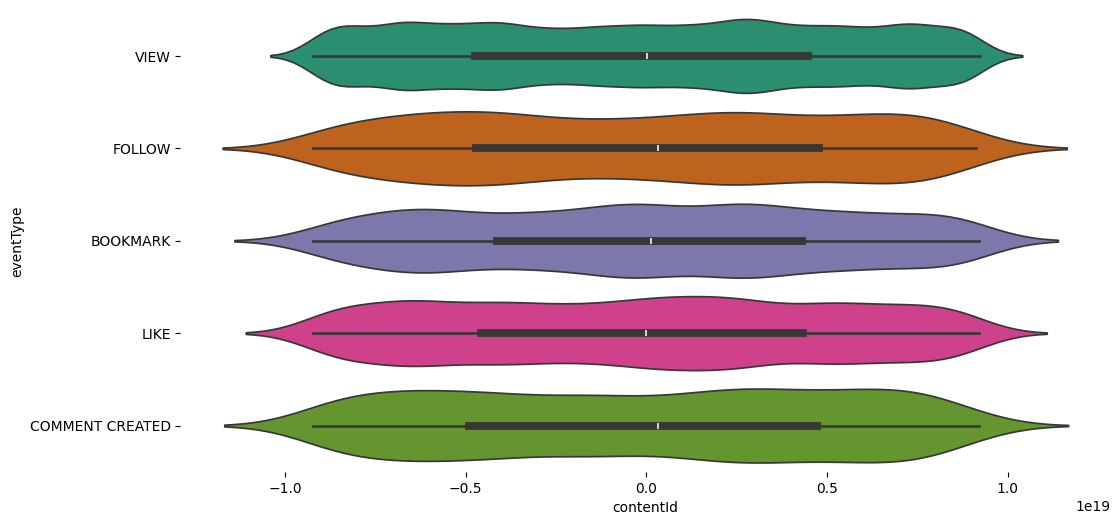

In [ ]:
# title eventType vs contentId

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(users['eventType'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(users, x='contentId', y='eventType', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

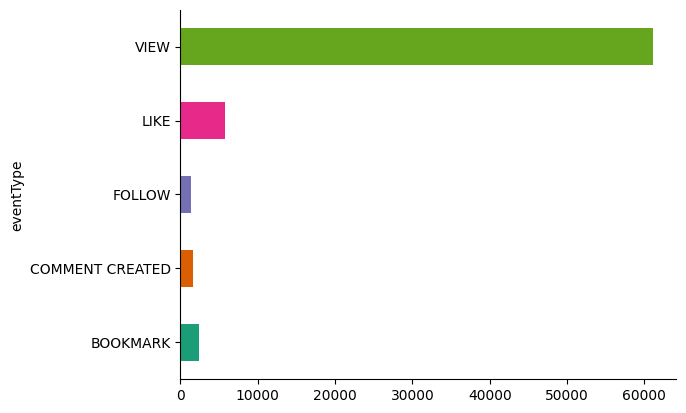

In [ ]:
# title eventType

from matplotlib import pyplot as plt
import seaborn as sns
users.groupby('eventType').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
#drop duplicates
articles.drop_duplicates(subset=['contentId'], inplace=True)
users.drop_duplicates(subset=['contentId'], inplace=True)


In [ ]:
articles.shape

(3057, 13)

In [ ]:
users.shape

(2987, 8)

In [ ]:
articles.describe


<bound method NDFrame.describe of        timestamp        eventType            contentId       authorPersonId  \
0     1459192779  CONTENT REMOVED -6451309518266745024  4340306774493623681   
1     1459193988   CONTENT SHARED -4110354420726924665  4340306774493623681   
2     1459194146   CONTENT SHARED -7292285110016212249  4340306774493623681   
3     1459194474   CONTENT SHARED -6151852268067518688  3891637997717104548   
4     1459194497   CONTENT SHARED  2448026894306402386  4340306774493623681   
...          ...              ...                  ...                  ...   
3117  1487946604   CONTENT SHARED  9213260650272029784  3609194402293569455   
3118  1487947067   CONTENT SHARED -3295913657316686039  6960073744377754728   
3119  1488223224   CONTENT SHARED  3618271604906293310  1908339160857512799   
3120  1488300719   CONTENT SHARED  6607431762270322325 -1393866732742189886   
3121  1488307871   CONTENT SHARED  4109618890343020064  3891637997717104548   

          authorSessionId                                    authorUserAgent  \
0     8940341205206233829                                               none   
1     8940341205206233829                                               none   
2     8940341205206233829                                               none   
3    -1457532940883382585                                               none   
4     8940341205206233829                                               none   
...                   ...                                                ...   
3117  7144190892417579456  Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...   
3118 -8193630595542572738  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3...   
3119  -183341653743161643  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_0...   
3120  2367029511384577082  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   
3121 -7416795577834806518  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   

     authorRegion authorCountry contentType  \
0            none          none        HTML   
1            none          none        HTML   
2            none          none        HTML   
3            none          none        HTML   
4            none          none        HTML   
...           ...           ...         ...   
3117           SP            BR        HTML   
3118           GA            US        HTML   
3119           SP            BR        HTML   
3120           MG            BR        HTML   
3121           SP            BR        HTML   

                                                    url  \
0     http://www.nytimes.com/2016/03/28/business/dea...   
1     http://www.nytimes.com/2016/03/28/business/dea...   
2     http://cointelegraph.com/news/bitcoin-future-w...   
3     https://cloudplatform.googleblog.com/2016/03/G...   
4     https://bitcoinmagazine.com/articles/ibm-wants...   
...                                                 ...   
3117  https://startupi.com.br/2017/02/liga-ventures-...   
3118  https://thenextweb.com/apps/2017/02/14/amazon-...   
3119                        https://code.org/about/2016   
3120  https://www.bloomberg.com/news/articles/2017-0...   
3121  https://www.acquia.com/blog/partner/2017-acqui...   

                                                  title  \
0     Ethereum, a Virtual Currency, Enables Transact...   
1     Ethereum, a Virtual Currency, Enables Transact...   
2     Bitcoin Future: When GBPcoin of Branson Wins O...   
3                          Google Data Center 360° Tour   
4     IBM Wants to "Evolve the Internet" With Blockc...   
...                                                 ...   
3117  Conheça a Liga IoT, plataforma de inovação abe...   
3118  Amazon takes on Skype and GoToMeeting with its...   
3119                        Code.org 2016 Annual Report   
3120  JPMorgan Software Does in Seconds What Took La...   
3121               The 2017 Acquia Partners of the Year   

                                                   text lang  
0     All 

In [ ]:

articles['content']= articles['title'] + articles['text']

text = articles['content'][1]
doc = nlp(text)
print([(X.text, X.label_) for X in doc.ents if X.label_ not in ['DATE','CARDINAL','ORDINAL','MONEY','TIME']])

<ipython-input-62-2ce0fc9ab4ce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles['content']= articles['title'] + articles['text']


[('Virtual Currency', 'ORG'), ('Ethereum', 'ORG'), ('Bitcoin', 'PERSON'), ('Bitcoin', 'PERSON'), ('Ethereum', 'ORG'), ('Bitcoin', 'PERSON'), ('Ethereum', 'ORG'), ('Bitcoin', 'PERSON'), ('Ethereum', 'ORG'), ('Ponzi', 'ORG'), ('Ethereum', 'ORG'), ('America', 'GPE'), ('IBM', 'ORG'), ('Ethereum', 'ORG'), ('Microsoft', 'ORG'), ('Ethereum', 'ORG'), ('Marley Gray', 'PERSON'), ('Microsoft', 'ORG'), ('Gray', 'PERSON'), ('Microsoft', 'ORG'), ('Bitcoin', 'PERSON'), ('Wikipedia', 'GPE'), ('Ethereum', 'ORG'), ('Ethereum', 'ORG'), ('Ethereum', 'ORG'), ('Blockchain: Tapping I nto the Real Potential , Cutting Through the Hype', 'WORK_OF_ART'), ('Ethereum', 'ORG'), ('JPMorgan', 'ORG'), ('Masala', 'GPE'), ('Ethereum', 'ORG'), ('Michael Novogratz', 'PERSON'), ('Fortress Investing Group', 'ORG'), ('Fortress', 'PERSON'), ('Bitcoin', 'PERSON'), ('Ethereum', 'ORG'), ('Fortress', 'GPE'), ('Novogratz', 'PERSON'), ('Ether', 'GPE'), ('Ether', 'GPE'), ('Bitcoin', 'PERSON'), ('Bitcoin', 'PERSON'), ('Bitcoin', 'PER

In [ ]:
article = nlp(text)
len(article.ents)

104

In [ ]:
labels = [x.label_ for x in article.ents if x.label_ not in ['DATE','CARDINAL','ORDINAL','MONEY','TIME']]
Counter(labels)

Counter({'ORG': 37, 'PERSON': 26, 'GPE': 11, 'WORK_OF_ART': 1, 'NORP': 1})

In [ ]:
# Count the frequncy of each keywords
items = [x.text for x in article.ents if x.label_ not in ['DATE','CARDINAL','ORDINAL','MONEY','TIME']]
Counter(items).most_common(20)

[('Ethereum', 21),
 ('Bitcoin', 14),
 ('Microsoft', 3),
 ('Ether', 3),
 ('Buterin', 3),
 ('Fortress', 2),
 ('ConsenSys', 2),
 ('Brooklyn', 2),
 ('Virtual Currency', 1),
 ('Ponzi', 1),
 ('America', 1),
 ('IBM', 1),
 ('Marley Gray', 1),
 ('Gray', 1),
 ('Wikipedia', 1),
 ('Blockchain: Tapping I nto the Real Potential , Cutting Through the Hype',
  1),
 ('JPMorgan', 1),
 ('Masala', 1),
 ('Michael Novogratz', 1),
 ('Fortress Investing Group', 1)]

##Generate tags for each article in our dataset


In [ ]:
# take the top 5 most frequent keywords as tags of this article
x = Counter(items)
tags = sorted(x, key=x.get, reverse=True)
tags[0:5]

def get_tags(x):

    article = nlp(x)

    items = [x.text for x in article.ents if x.label_ not in ['DATE','CARDINAL','ORDINAL','MONEY']]

    tags_value = Counter(items)

    tags = sorted(tags_value, key=tags_value.get, reverse=True)

    return tags[0:5]
articles['tags'] = articles['content'].apply(lambda x: get_tags(x))
# drop duplicate by a column name

articles = articles.drop_duplicates(['title'], keep='last')

articles = articles.drop_duplicates(['contentId'], keep='last')



<ipython-input-67-a9733f383ec8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles['tags'] = articles['content'].apply(lambda x: get_tags(x))


In [ ]:
articles.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,none,none,none,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,none,none,none,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,none,none,none,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,none,none,none,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,none,none,none,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


<ipython-input-26-f69e524c6105>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'contentType', data = articles, palette = 'viridis')


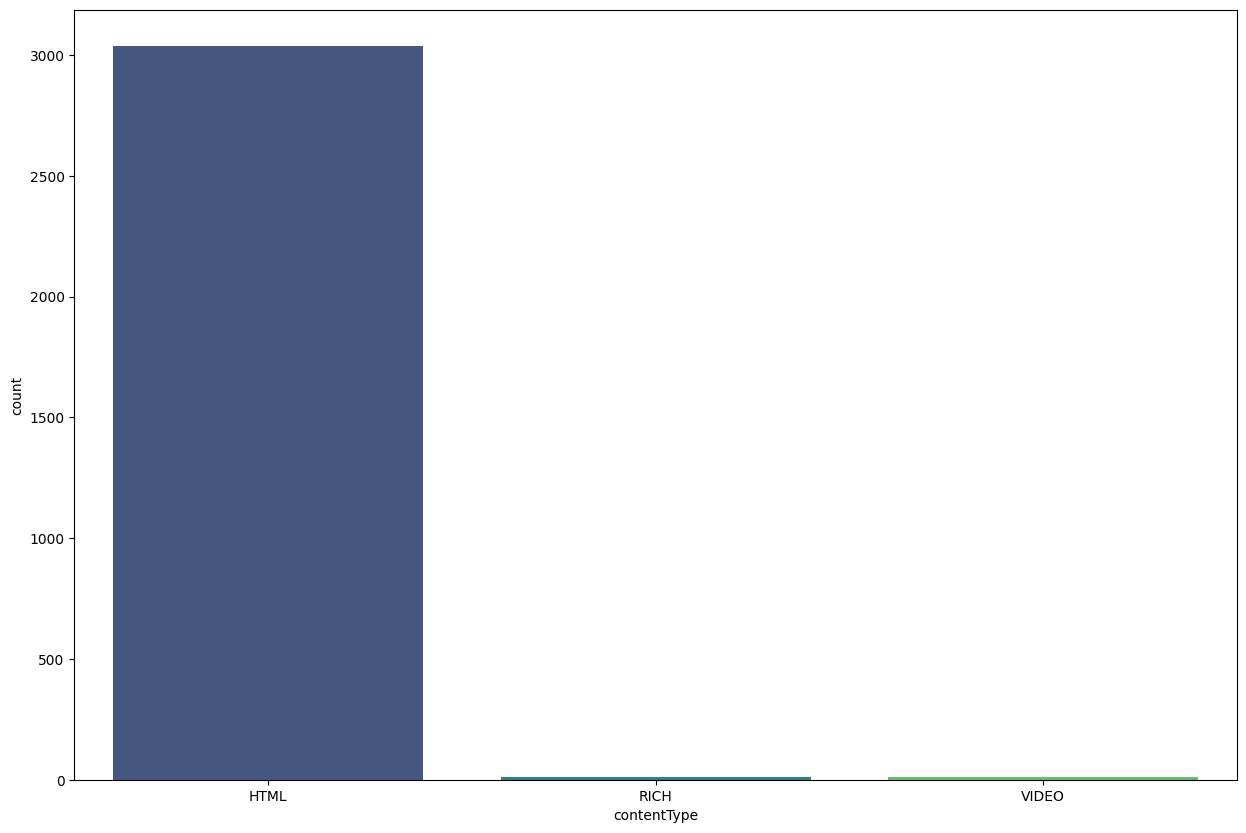

In [ ]:

plt.figure(figsize = (15, 10))
sns.countplot(x = 'contentType', data = articles, palette = 'viridis')
plt.show()


In [ ]:
articles = articles[articles.lang == 'en']
def text_extractor(series):
    text = []
    for i in range(len(series)):
        text.append(series.iloc[i])
    return text


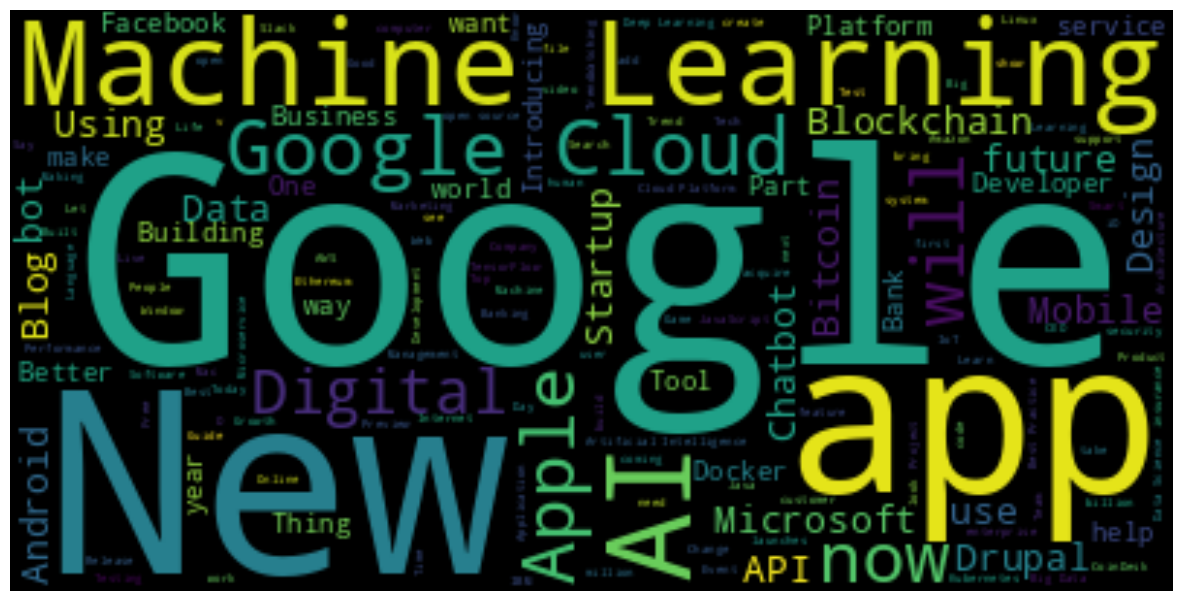

In [ ]:
title_text = ' '.join(text_extractor(articles['title']))
plt.figure(figsize = (15, 10))
wordcloud = WordCloud().generate(title_text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

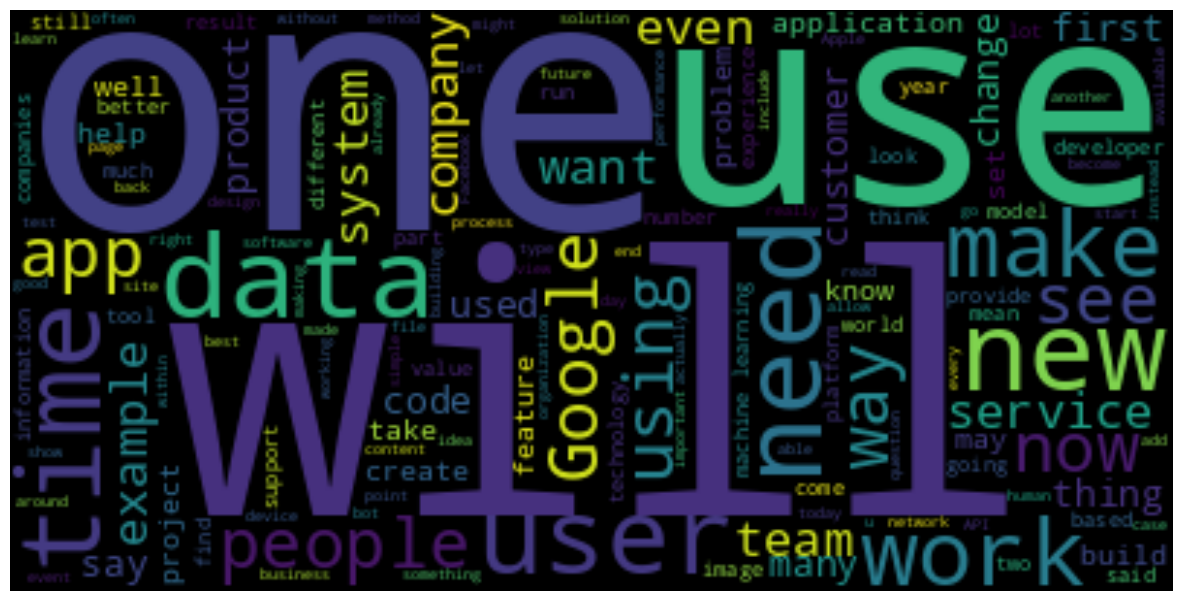

In [ ]:
main_text = ' '.join(text_extractor(articles['text']))
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(49,51))

plt.figure(figsize = (15, 10))
wordcloud = WordCloud().generate(main_text)
plt.imshow(wordcloud, interpolation = 'bilinear')

wordcloud.recolor(color_func = grey_color_func)
plt.axis("off")
plt.show()

In [ ]:
def decontracted(phrase):
    """
    This function would convert some short letters into the forms that one
    could easily understand respectively.
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def text_preprocessing(df, feature, stemming = False, lemmatize = True):
    pattern = "[^a-zA-Z0-9]"
    english_stopwords = stopwords.words("english")
    preprocessed_text = []
    for i in tqdm(range(len(df[feature]))):
        text = decontracted(df[feature].iloc[i])
        text = re.sub(pattern, ' ', text)
        text = text.lower()
        text = word_tokenize(text)
        text = [word for word in text if word not in english_stopwords]
        text = [word for word in text if word not in string.punctuation]
        if stemming:
            porter_stemmer = PorterStemmer()
            text = " ".join([porter_stemmer.stem(word) for word in text])
        if lemmatize:
            lemmatizer = WordNetLemmatizer()
            text = " ".join([lemmatizer.lemmatize(word) for word in text])
        preprocessed_text.append(text)

    return preprocessed_text

In [ ]:


preprocessed_text = text_preprocessing(articles , feature = "text")
preprocessed_title = text_preprocessing(articles , feature = "title")


100%|██████████| 2218/2218 [00:00<00:00, 4304.78it/s]


In [ ]:
articles_main = articles[articles['lang'] == 'en']


Principal Component Analysis


In [ ]:

vectorizer_text = TfidfVectorizer(stop_words = 'english')
vectorizer_title = TfidfVectorizer(stop_words = 'english')

In [ ]:

tfidf_vectorizer_text = vectorizer_text.fit_transform(preprocessed_text)
tfidf_vectorizer_title = vectorizer_title.fit_transform(preprocessed_title)



In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
tfidf_array = scaler.fit_transform(tfidf_vectorizer_title.toarray())
tfidf_text_array = scaler.fit_transform(tfidf_vectorizer_text.toarray())

In [ ]:
from sklearn.decomposition import PCA
print("The size of the tfidf title array is: {}".format(tfidf_array.shape))
print("The size of the tfidf text array is: {}".format(tfidf_text_array.shape))

The size of the tfidf title array is: (2218, 4132)
The size of the tfidf text array is: (2218, 40459)


##PCA for Tfidf Title *array*

In [ ]:
number_of_components = 2218
pca_model = PCA(n_components = number_of_components)
pca_model.fit(tfidf_array)

PCA(n_components=2218)

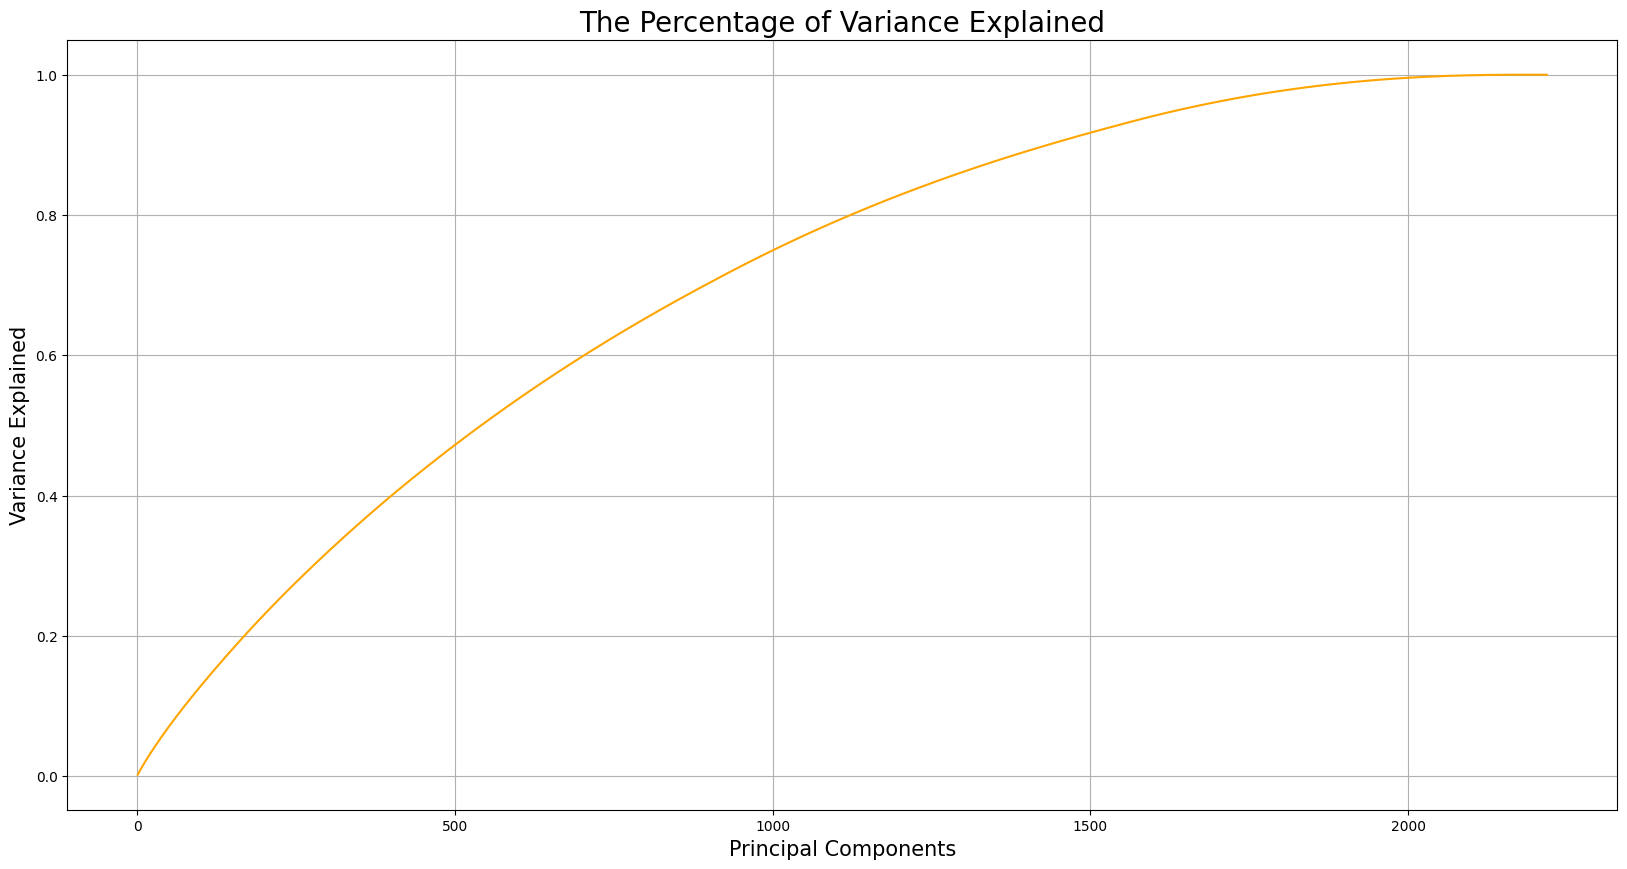

In [ ]:
total_components = list(range(1, number_of_components + 1))
plt.figure(figsize = (20, 10))
sns.lineplot(x = total_components, y = np.cumsum(pca_model.explained_variance_ratio_), color = 'orange')
plt.xlabel('Principal Components', fontsize = 15)
plt.ylabel('Variance Explained', fontsize = 15)
plt.title("The Percentage of Variance Explained", fontsize = 20)
plt.grid(True)
#plt.savefig('Plots/Percentage of Variance Explained.png')
plt.show()

In [ ]:
ideal_principal_components = 1500
pca_model = PCA(n_components = ideal_principal_components)
tfidf_title_reduced = pca_model.fit_transform(tfidf_array)
tfidf_title_reduced.shape

(2218, 1500)

In [ ]:
print("The initial dimensions of the vectorized_text: {}".format(tfidf_vectorizer_title.shape))
print("The final dimensions of the vectorized text: {}".format(tfidf_title_reduced.shape))

The initial dimensions of the vectorized_text: (2218, 4132)
The final dimensions of the vectorized text: (2218, 1500)


##PCA for Tfidf Text Array

In [ ]:
number_of_components = 2000
pca_model = PCA(n_components = number_of_components)
pca_model.fit(tfidf_text_array)
PCA(n_components=2000)


PCA(n_components=2000)

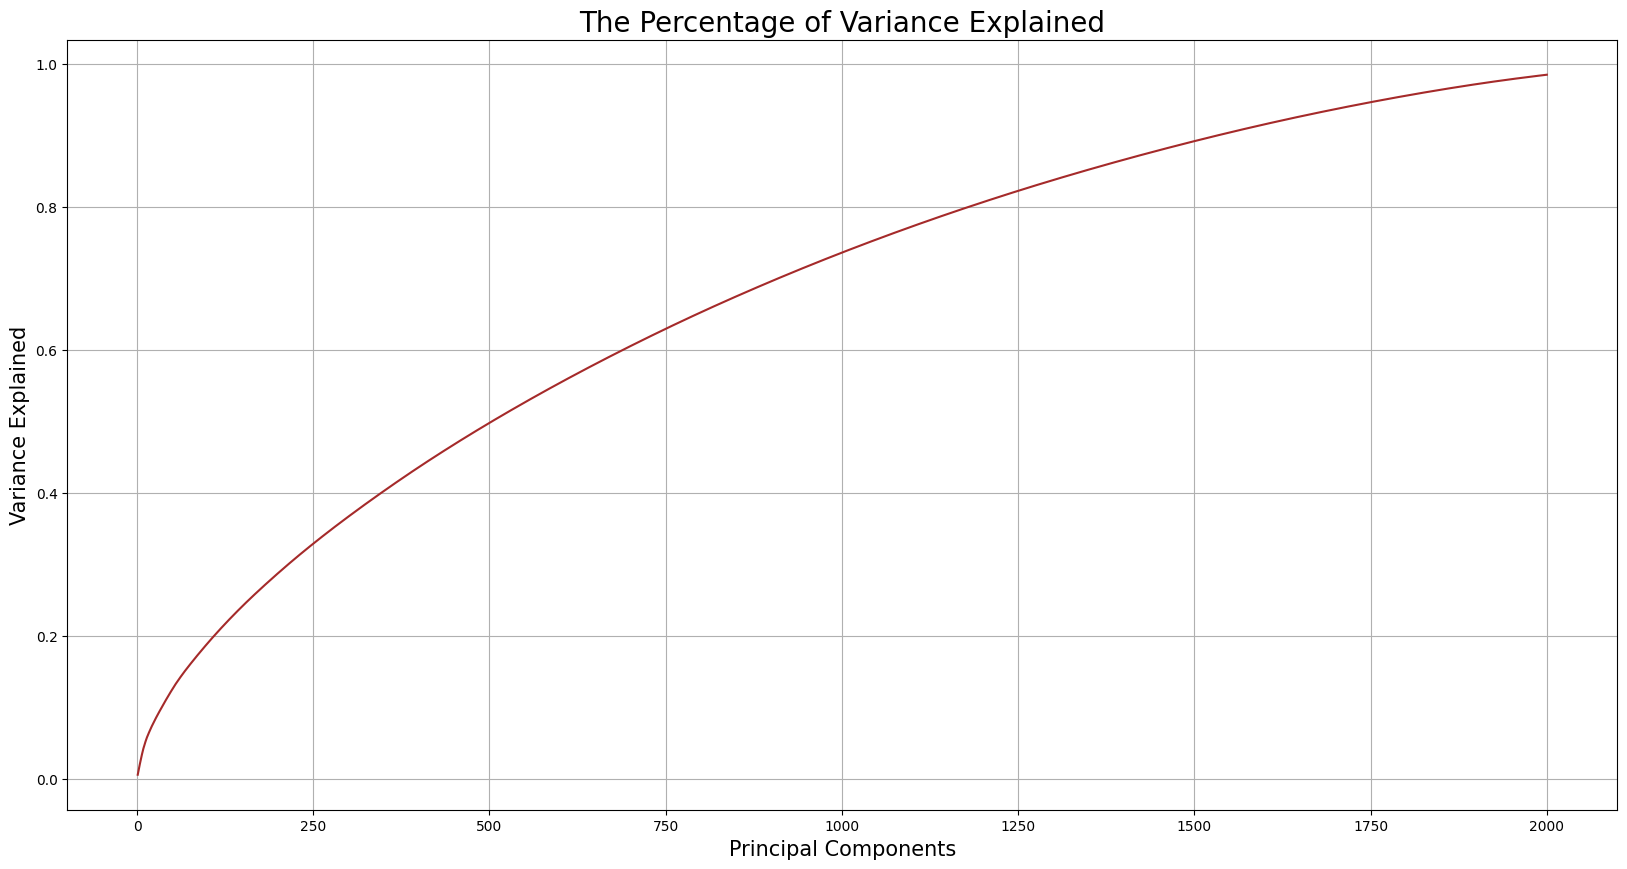

In [ ]:
total_components = list(range(1, number_of_components + 1))
plt.figure(figsize = (20, 10))
sns.lineplot(x = total_components, y = np.cumsum(pca_model.explained_variance_ratio_), color = 'brown')
plt.xlabel('Principal Components', fontsize = 15)
plt.ylabel('Variance Explained', fontsize = 15)
plt.title("The Percentage of Variance Explained", fontsize = 20)
plt.grid(True)
#plt.savefig('Plots/Percentage of Variance Explained.png')
plt.show()

In [ ]:
ideal_principal_components = 1750
pca_model = PCA(n_components = ideal_principal_components)
tfidf_text_reduced = pca_model.fit_transform(tfidf_text_array)
print("The initial dimensions of the vectorized_text: {}".format(tfidf_vectorizer_text.shape))
print("The final dimensions of the vectorized text: {}".format(tfidf_text_reduced.shape))

The initial dimensions of the vectorized_text: (2218, 40459)
The final dimensions of the vectorized text: (2218, 1750)


In [ ]:
print(tfidf_title_reduced.shape)
print(tfidf_text_reduced.shape)
tfidf_total = np.concatenate((tfidf_title_reduced, tfidf_text_reduced), axis = 1)

(2218, 1500)
(2218, 1750)


K-Means Clustering

In [ ]:
best_k = 11
k_model_text = KMeans(n_clusters = best_k, init = 'k-means++', max_iter = 500, n_init = best_k, random_state = 18)
k_model_text.fit(tfidf_total)
KMeans(max_iter=500, n_clusters=11, n_init=11, random_state=18)
articles_main["clusters_text"] = k_model_text.labels_

NameError: name 'KMeans' is not defined

In [ ]:
from sklearn.cluster import KMeans
# sum of the squared Euclidean distances of each point to its closest centroid
sse = {}

for i in tqdm(range(2,40)):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100,random_state=18).fit(tfidf_total)
    sse[i] = kmeans.inertia_

# Plotting the curve with 'k'-value vs distance
plt.figure(figsize=(20,10))
plt.plot(list(sse.keys()), list(sse.values()), marker='o', color = 'red')
plt.xlabel("Number of clusters", fontsize = 10)
plt.ylabel("Inertia", fontsize = 10)
plt.title("Elbow Plot for K-means - Clustering based on Text of the articles", fontsize = 15)
plt.grid(True)
plt.show()

In [ ]:
sse = {}

for i in range(2,40):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100,random_state=18).fit(tfidf_vectorizer_text)
    sse[i] = kmeans.inertia_
# Plotting the curve with 'k'-value vs distance
plt.figure(figsize=(12,6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Plot for K-means - Clustering based on Text of the articles")

In [ ]:
res = {}
for i in range(2,40):

    model = KMeans(n_clusters = i,random_state=18).fit(tfidf_vectorizer_text)
    pred = model.predict(tfidf_vectorizer_text)
    res[i] = silhouette_score(tfidf_vectorizer_text, pred)
optimum = max(res, key=res.get)
print(optimum)
res

The coefficient combines the average within-cluster distance with average nearest-cluster distance to assign a value between -1 and 1. A value below zero denotes that the observation is probably in the wrong cluster and a value closer to 1 denotes that the observation is a great fit for the cluster and clearly separated from other clusters.



In [ ]:
 articles_main.head()

##Two Dimensional representation using PCA

In [ ]:
tfidf_vectorizer_text



In [ ]:
tfidf_vectorizer_title


In [ ]:
pca = PCA(n_components = 2)
two_dim_representation = pca.fit_transform(tfidf_vectorizer_text.toarray())
two_dim_representation.shape

In [ ]:
kmeans = KMeans(n_clusters = 11)
label = kmeans.fit_predict(two_dim_representation)

#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)

#plotting the results:
plt.figure(figsize = (20, 20))
for i in u_labels:
    plt.scatter(two_dim_representation[label == i , 0] , two_dim_representation[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

#Three Dimensional Representation using PCA



In [ ]:
dim_reduction_df = pd.DataFrame()
pca = PCA(n_components = 3)
three_dim_representation = pca.fit_transform(tfidf_vectorizer_text.toarray())
dim_reduction_df['pca-one'] = three_dim_representation[:, 0]
dim_reduction_df['pca-two'] = three_dim_representation[:, 1]
dim_reduction_df['pca-three'] = three_dim_representation[:, 2]

In [ ]:

kmeans = KMeans(n_clusters = 11)
label = kmeans.fit_predict(three_dim_representation)
dim_reduction_df['clusters'] = label
dim_reduction_df.head()


In [ ]:
dim_reduction_df['pca-one']

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    xs=dim_reduction_df["pca-one"],
    ys=dim_reduction_df["pca-two"],
    zs=dim_reduction_df["pca-three"],
    c=dim_reduction_df["clusters"],
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

##Two Dimensional Representation using TSNE


> Add blockquote



In [ ]:
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")


tsne = TSNE(n_components = 2, perplexity = 40, n_iter = 300)
two_dim_representation = tsne.fit_transform(tfidf_vectorizer_text.toarray())
two_dim_representation.shape

In [ ]:
kmeans = KMeans(n_clusters = 11)
label = kmeans.fit_predict(two_dim_representation)

In [ ]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)

#plotting the results:
plt.figure(figsize = (20, 20))
for i in u_labels:
    plt.scatter(two_dim_representation[label == i , 0] , two_dim_representation[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

## Three Dimensional Representation using TSNE

In [ ]:
dim_reduction_df = pd.DataFrame()


tsne = TSNE(n_components = 3, perplexity = 40, n_iter = 300)
three_dim_representation = tsne.fit_transform(tfidf_vectorizer_text.toarray())
dim_reduction_df['tsne-one'] = three_dim_representation[:, 0]
dim_reduction_df['tsne-two'] = three_dim_representation[:, 1]
dim_reduction_df['tsne-three'] = three_dim_representation[:, 2]

In [ ]:
kmeans = KMeans(n_clusters = 11)

label = kmeans.fit_predict(three_dim_representation)
dim_reduction_df['clusters'] = label

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    xs=dim_reduction_df["tsne-one"],
    ys=dim_reduction_df["tsne-two"],
    zs=dim_reduction_df["tsne-three"],
    c=dim_reduction_df["clusters"],
    cmap='tab10'
)
ax.set_xlabel('tsne-one')
ax.set_ylabel('tsne-two')
ax.set_zlabel('tsne-three')
plt.show()

##Two Dimensional Representation using Kernel PCA


In [ ]:
from sklearn.decomposition import KernelPCA


pca = KernelPCA(n_components = 2, kernel = 'rbf')
two_dim_representation = pca.fit_transform(tfidf_vectorizer_text.toarray())
two_dim_representation.shape

In [ ]:
kmeans = KMeans(n_clusters = 11)
label = kmeans.fit_predict(two_dim_representation)


#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)

#plotting the results:
plt.figure(figsize = (20, 20))
for i in u_labels:
    plt.scatter(two_dim_representation[label == i , 0] , two_dim_representation[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

##Three Dimensional Representation using Kernel PCA


In [ ]:
dim_reduction_df = pd.DataFrame()

pca = KernelPCA(n_components = 3, kernel = 'poly')
three_dim_representation = pca.fit_transform(tfidf_vectorizer_text.toarray())
dim_reduction_df['pca-one'] = three_dim_representation[:, 0]
dim_reduction_df['pca-two'] = three_dim_representation[:, 1]
dim_reduction_df['pca-three'] = three_dim_representation[:, 2]

kmeans = KMeans(n_clusters = 11)
label = kmeans.fit_predict(three_dim_representation)

dim_reduction_df['clusters'] = label

dim_reduction_df.head()

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    xs=dim_reduction_df["pca-one"],
    ys=dim_reduction_df["pca-two"],
    zs=dim_reduction_df["pca-three"],
    c=dim_reduction_df["clusters"],
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## K-means Clustering Optimization

In [ ]:
best_k = optimum
k_model_text = KMeans(n_clusters=best_k, init='k-means++', max_iter=500, n_init=best_k,random_state=18)
k_model_text.fit(tfidf_vectorizer_text)

In [ ]:
articles["clusters_text"] = k_model_text.labels_
articles.head()


In [ ]:
order_centroids = k_model_text.cluster_centers_.argsort()[:, ::-1]
words = vectorizer_text.get_feature_names_out()

for i in range(best_k):
    cloud = []
#     print("Cluster %d:" % i),
    for ind in order_centroids[i, :best_k]:
#         print(' %s' % words[ind]),
        cloud.append(words[ind])

    wordcloud = WordCloud(width = 300, height = 200,
            background_color ='white',
            min_font_size = 10).generate(' '.join(cloud))

    # plot the WordCloud image
    plt.figure(figsize = (8, 6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('Top words in cluster '+ str(i)+': based on text \n',fontsize=18)
    plt.show()

##Clustering for "TFIDF" Title based

In [ ]:

# sum of the squared Euclidean distances of each point to its closest centroid
sse = {}
for i in range(2,40):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100,random_state=18).fit(tfidf_vectorizer_title)
    sse[i] = kmeans.inertia_
# Plotting the curve with 'k'-value vs distance
plt.figure(figsize=(12,6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Plot for K-means - Clustering based on Text of the articles")

In [ ]:

res = {}
for i in range(2,40):

    model = KMeans(n_clusters = i,random_state=18).fit(tfidf_vectorizer_title)
    pred = model.predict(tfidf_vectorizer_title)
    res[i] = silhouette_score(tfidf_vectorizer_title, pred)

optimum = max(res, key=res.get)
print(optimum)
res

In [ ]:

best_k = optimum
k_model_title = KMeans(n_clusters=best_k, init='k-means++', max_iter=500, n_init=best_k,random_state=18)
k_model_title.fit(tfidf_vectorizer_text)
k_model_title.fit(tfidf_vectorizer_title)

articles["clusters_title"] = k_model_title.labels_


In [ ]:
# print("Top words in each cluster by Titles :")
order_centroids = k_model_title.cluster_centers_.argsort()[:, ::-1]
words = vectorizer_title.get_feature_names_out()


for i in range(best_k):
    cloud = []
#     print("Cluster %d:" % i),
    for ind in order_centroids[i, :best_k]:
#         print(' %s' % words[ind]),
        cloud.append(words[ind])

    wordcloud = WordCloud(width = 300, height = 200,
            background_color ='white',
            min_font_size = 10).generate(' '.join(cloud))

    # plot the WordCloud image
    plt.figure(figsize = (8, 6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('Top words in cluster '+ str(i)+': based on titles \n',fontsize=18)
    plt.show()

##K-means  Clustering Recommendations

In [ ]:
def cluster_predict(input_txt,text = True, title = False):

    if text:
        clu = vectorizer_text.transform((input_txt))
        pred = k_model_text.predict(clu)
    if title:
        clu = vectorizer_title.transform((input_txt))
        pred = k_model_title.predict(clu)

    return pred

def recommend(input_txt,text=True,title=False):

    # Predicting the cluster
    prediction = (cluster_predict(input_txt,text,title))

    # Based on the above prediction 10 random articles are recommended from the whole data-frame

    if text:
        temp = articles[articles['clusters_text'] == prediction[0]]
    if title:
        temp = articles[articles['clusters_title'] == prediction[0]]

    temp = temp.sample(5)
    print('Cluster number is: ',prediction[0])

    return set(temp['title'])

In [ ]:
user_input = ['human arm during the entire dressing process. That, in turn, affects the amount of force the robot has to apply to pull the article of clothing — such as a long-sleeve shirt — from the hand to the shoulder.'] #change the input
res = recommend(user_input, True, False)

print('Recommending top 5 articles according to the user input based on text:')
res

In [ ]:
user_input = ['Learning to think critically about machine learning'] #change the input
res = recommend(user_input, False, True)

print('Recommending top 5 articles according to the user input based on title:')
res

## Merging the user interactions with scoring methods and using this evaluation

In [ ]:
users_train, users_test = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'],
                                   test_size=0.20,
                                   random_state=42)


In [ ]:
articles = articles[articles['eventType'] == 'CONTENT SHARED']


In [ ]:
print('# interactions on Train set: %d' % len(users_train))
print('# interactions on Test set: %d' % len(users_test))
# interactions on Train set: 31284
# interactions on Test set: 7822


# interactions on Train set: 1677
# interactions on Test set: 420


In [ ]:
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = users_train.set_index('personId')
interactions_test_indexed_df = users_test.set_index('personId')

In [ ]:
def get_items_interacted(person_id, users):
    interacted_items = users.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])


In [ ]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])
        interacted_items_count_testset = len(person_interacted_items_testset)

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id,
                                               items_to_ignore=get_items_interacted(person_id,
                                                                                    interactions_train_indexed_df),
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id,
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items,
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count,
                          'hits@10_count':hits_at_10_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)

        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())

        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}
        return global_metrics, detailed_results_df

model_evaluator = ModelEvaluator()

#Content based Recommendations

In [ ]:

stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = articles['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles['title'] + "" + articles['text'])
tfidf_feature_names = vectorizer.get_feature_names_out()
print(tfidf_matrix[0:0 + 1])


  (0, 6)	0.023655731093026423
  (0, 929)	0.02333116393983289
  (0, 1285)	0.02567759207911732
  (0, 358)	0.02044850604698216
  (0, 4146)	0.0220791992035675
  (0, 4128)	0.03037297150891773
  (0, 4985)	0.023410423243605438
  (0, 2511)	0.0465061931011091
  (0, 4514)	0.02593088053511647
  (0, 4653)	0.026197163700170296
  (0, 1767)	0.026062314987178453
  (0, 4158)	0.025436088834891703
  (0, 2710)	0.023100397790555182
  (0, 2376)	0.02253090863531954
  (0, 3641)	0.020141752818154158
  (0, 2512)	0.016760604341019995
  (0, 2787)	0.02677457863336791
  (0, 2942)	0.02567759207911732
  (0, 325)	0.013951385904396096
  (0, 139)	0.017575671020934814
  (0, 1280)	0.016294125671549017
  (0, 1238)	0.023410423243605438
  (0, 4986)	0.010925852118349375
  (0, 4)	0.012516358130799802
  (0, 2600)	0.013518003460936352
  :	:
  (0, 2039)	0.018268883696912472
  (0, 3967)	0.015505471228973179
  (0, 3906)	0.03746116738194515
  (0, 3466)	0.04185415771318829
  (0, 2558)	0.022879454508080845
  (0, 4455)	0.01596034903650

In [ ]:
import numpy as np
import scipy
import sklearn.preprocessing

def get_item_profile(item_id):
    idx = item_ids.index(item_id)  # Ensure item_ids is defined and correct
    item_profile = tfidf_matrix[idx:idx + 1]
    return item_profile

def get_item_profiles(ids):
    if not isinstance(ids, list):  # Check if `ids` is a list
        raise TypeError("ids should be a list or iterable structure.")

    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)  # Stacking sparse matrices
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    ids = interactions_person_df['contentId'].tolist()  # Ensure a list
    user_item_profiles = get_item_profiles(ids)  # Now it should work

    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1, 1)
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(np.asarray(user_item_strengths_weighted_avg))

    return user_profile_norm

def build_users_profiles():
    interactions_indexed_df = interactions_full_df[interactions_full_df['contentId'] \
                                                   .isin(articles['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

This method tokenizes the text, counts the occurrences of each unique word, and returns a sparse matrix where rows represent titles and columns represent unique words.

In [ ]:

user_profiles = build_users_profiles()
len(user_profiles)

TypeError: ids should be a list or iterable structure.

In [ ]:
myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names,
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

The linear kernel is equivalent to the dot product, measuring similarity based on word counts. Flattening the result converts the 2D output into a 1D array, making it easier to work with.